# A/B тестирование количества сыгранных игроками раундов в игре Cookie Cats.
"Cookie Cats — чрезвычайно популярная мобильная игра-головоломка, разработанная Tactile Entertainment. Это классическая игра-головоломка в стиле «соедини три», в которой игрок должен соединять плитки одного цвета, чтобы очистить игровое поле и выиграть уровень. Также здесь представлены поющие кошки."

"По мере прохождения уровней игры игроки время от времени сталкиваются с воротами, которые заставляют их ждать нетривиальное количество времени или совершать покупки в приложении для продвижения. Помимо стимулирования покупок в приложении, эти ворота служат важной цели: дать игрокам вынужденный перерыв в игре, что, как мы надеемся, приведет к увеличению и продлению удовольствия игрока от игры."

"Но где должны быть расположены ворота? Изначально первые ворота были размещены на уровне 30, но в этом блокноте мы собираемся проанализировать AB-тест, в котором мы переместили первые ворота в Cookie Cats с уровня 30 на уровень 40. В частности, мы рассмотрим влияние на удержание игроков. Но прежде чем мы доберемся до этого, ключевым шагом перед проведением любого анализа является понимание данных. Итак, давайте загрузим его и посмотрим!"

In [143]:
# Ипортируем требующиеся библиотеки.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

%matplotlib inline

In [144]:
# Считываем датасет и выводим первые 5 строк.
data=pd.read_csv('C:/Users/ilyal/my_lessons/cookie_cats.csv')
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [32]:
# Смотрим на отсутствие значений в колонках.
data.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [6]:
# Разделяем датафрейм на контрольную и тестовую группы.
control=data[data['version']=='gate_30']
test=data[data['version']=='gate_40']

Посмотрим на распределения количества раундов, сыгранных игроками. В контрольной группе присутствует сильный выброс (возможно, техническая ошибка или так называемый "абуз" со стороны игрока). Удалим этот выброс. Далее изобразим распределения на графиках.


In [27]:
# Количество раундов в контрольной группе.
control_dist_rounds=control.groupby('sum_gamerounds', as_index=False).agg({'userid':'count'})
control_dist_rounds=control_dist_rounds.iloc[0:778]
control_dist_rounds

,sum_gamerounds,userid
0,0,1937
1,1,2749
2,2,2198
3,3,1899
4,4,1831
...,...,...
773,1906,1
774,2156,1
775,2251,1
776,2438,1


In [31]:
# Количество раундов в тестовой группе.
test_dist_rounds=test.groupby('sum_gamerounds', as_index=False).agg({'userid':'count'})
test_dist_rounds

,sum_gamerounds,userid
0,0,2057
1,1,2789
2,2,2408
3,3,2059
4,4,1798
...,...,...
787,2015,1
788,2063,1
789,2124,1
790,2294,1


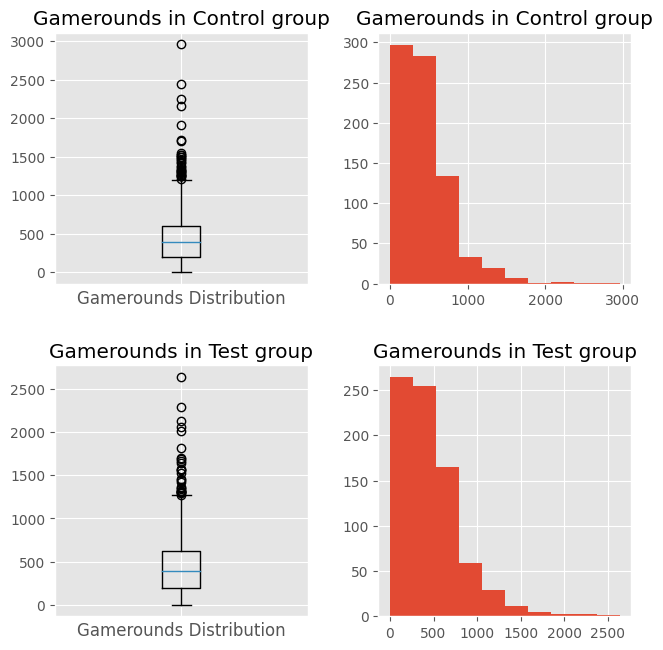

In [95]:
# Изобразим графики.
plt.style.use('ggplot')
fig, ax=plt.subplots(2, 2)
fig.set_figheight(7)
fig.set_figwidth(7)

ax[0, 0].boxplot(control_dist_rounds['sum_gamerounds'])
ax[0, 0].set_title('Gamerounds in Control group')
ax[0, 0].set_xlabel('Gamerounds Distribution')
ax[0, 0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax[0, 1].hist(control_dist_rounds['sum_gamerounds'])
ax[0, 1].set_title('Gamerounds in Control group')

ax[1, 0].boxplot(test_dist_rounds['sum_gamerounds'])
ax[1, 0].set_title('Gamerounds in Test group')
ax[1, 0].set_xlabel('Gamerounds Distribution')
ax[1, 0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax[1, 1].hist(test_dist_rounds['sum_gamerounds'])
ax[1, 1].set_title('Gamerounds in Test group')

fig.tight_layout(pad=2.5)
plt.show()

Распределения ненормальны, присутствуют выбросы, количество наблюдений в выборках не равно. С учетом всего вышесказанного применим Bootstrap и сравним медианы в группах.

In [98]:
# Создаем одномерные массивы из значений количества раундов в группах.
control_array=np.array(control_dist_rounds['sum_gamerounds'])
test_array=np.array(test_dist_rounds['sum_gamerounds'])

In [115]:
# Применяем Bootstrap к контрольной группе.
stats.bootstrap((control_array, ), statistic=np.median)

BootstrapResult(confidence_interval=ConfidenceInterval(low=362.0, high=417.5), bootstrap_distribution=array([399.5, 385. , 392.5, ..., 400.5, 374.5, 392.5]), standard_error=14.245591591443281)

In [116]:
# Применяем Bootstrap к тестовой группе.
stats.bootstrap((test_array, ), statistic=np.median)

BootstrapResult(confidence_interval=ConfidenceInterval(low=368.0581753873654, high=424.0), bootstrap_distribution=array([379.5, 431. , 393. , ..., 390. , 386. , 396.5]), standard_error=14.336248179457506)

Доверительные интервалы медианных значений групп пересекаются, из этого следует, что медианы групп статистически значимо не отличаются.

Теперь сравним уровни удержания в первый день и в 7 день в группах. Для этого создадим 2 таблицы с перекрестными значениями (для каждого вида ретеншена) и применим критерий Хи-квадрат Пирсона.

In [139]:
# Создаем перекрестные таблицы.
data_crosstab_ret1=pd.crosstab(data['version'], data['retention_1'])
data_crosstab_ret7=pd.crosstab(data['version'], data['retention_7'])

In [140]:
# Применяем критерий для ретеншена первого дня.
stats.chi2_contingency(data_crosstab_ret1)

Chi2ContingencyResult(statistic=3.1591007878782262, pvalue=0.07550476210309086, dof=1, expected_freq=array([[24799.13514952, 19900.86485048],
       [25236.86485048, 20252.13514952]]))

In [141]:
# Применяем критерий для ретеншена седьмого дня.
stats.chi2_contingency(data_crosstab_ret7)

Chi2ContingencyResult(statistic=9.959086799559167, pvalue=0.0016005742679058301, dof=1, expected_freq=array([[36382.90257127,  8317.09742873],
       [37025.09742873,  8463.90257127]]))

<ul>
<li>Для ретеншена первого дня мы не выявили статистически значимых отличий в группах.
<li>Для ретеншена седьмого дня мы выявили статистически значимые отличия. Основываясь на значениях в перекрестной таблице и результатах применения критерия, мы можем сделать вывод, что ретеншен 7 дня статистически значимо уменьшился в тестовой группе.
<ul>

### Вывод
Качество нововведения оценивается на множестве параметров: удержание игроков; количество денег, потраченных игроками на игру и.т.д. С информацией, данной в этом датасете мы можем делать заключения только по параметрам удержания игроков и сыгранных ими раундов. Основываясь на нашем анализе мы можем сделать следующие выводы:
<ul>
<li>Количество раундов, сыгранных игроками не изменилось в тестовой группе.
<li>Удержание игроков на короткой дистанции в тестовой группе не изменилось, а на длинной дистанции стало меньше.
<ul>

##### Заключительный вывод: если наша цель повысить удержание пользователей, то изменять размещение первых ворот с 30 уровня до 40 НЕ стоит.